In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/two-sigma-case-study

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/two-sigma-case-study


In [ ]:
%%capture
!pip install optuna

# general packages
import joblib
import logging
import datetime
import sys
import os
import warnings

# data
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import missingno as msno
import random
from itertools import zip_longest
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew
import re
import statsmodels.api as sm


# ML and DL
import optuna
from optuna.trial import TrialState
from sklearn import preprocessing, impute
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor,ExtraTreesRegressor
import torch 
from torch import nn, optim
import torch.nn.functional as F
from xgboost import XGBRegressor

# options
pd.options.display.max_rows = 4000
%config Completer.use_jedi = False
plt.style.use('seaborn')
color = sns.color_palette()
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')



---



---


## Two Sigma Data Clinic Research Challenge:
### NYC Property Sales Data prediction

---


In this notebook I conduct a variety of analyses on Manhattan property sales data from 2020-2021.

My analyses can be summarised as the following
- 1. Build understanding through data cleaning and exploratory data analysis.
- 2. Conduct hypothesis tests to estimate relationships between key variables
- 3. Fit a wide range of machine learning and deep learning models to predict Manhattan property sales data.
<br><br><br>

**Motivation:**
Build supervised learning model to predict sale prices to uncover buy and sell opportunities for undervalued and overvalued properties, respectively. Although we would need real time property listing data to uncover inefficiencies in the Manhattan property market, building a predictive model with high performance would be the first step to detect said inefficiencies. 
<br><br>

**Loss metric:**:
Across predictive modeling tasks I optimize for RMSE. I chose RMSE over MAE because I am assuming we are sensitive to outliers in the target and particularly bad model predictions. On the other hand, results for MAE are more interpretable as they are on the same scale.
<br><br>

**Hypothesis:**
While I define formal null and alternative hypotheses (with OLS regression assumptions about the features and target) for the MLR hypothesis testing, my hypothesis for the predictive modeling is as follows: 

Increasing our feature set size, engineering features with denoising autoencoders, and increasing model complexity will allow use to improve upon baseline model performance (baseline model is OLS with restricted feature set). While this might be trivial, it will be interesting to see which techniques increase model performance and to what extent.



---
---


#### ***Table of Contents:***

#### 1. Data Preparation and exploratory data analysis 
> a. Missing data and outlier removal
<br>b. Encoding and scaling
<br>c. Exploratory data analysis
<br>

#### 2. Hypothesis Testing with Multiple Linear Regression
>a. Null Hypothesis testing for f-test and t-test
<br>b. Hypothesis testing and regression output
<br>

#### 3. Predictive modeling
>a. establish baseline model
<br>b. comparision of supervised learning methods on small feature set
<br>c. clean features for medium feature set
<br>d. comparision of supervised machine learning models on medium feature set
<br>e. neural network optimization, optimize with respect to network topology
<br>e. denoising autoencoder, optimize with respect to network topology
<br>f. denoising autoencode latent feature extraction
<br>g. neural network prediction on denoised feature set
<br>
#### 4. Takeaways and next steps
>a. Data cleaning
<br>b. EDA
<br>c. Hypothesis testing
<br>d. Predictive modeling
<br>e. Time spent
<br>

---
---




In [ ]:
sales_df_raw = pd.read_csv('rollingsales_manhattan_2.csv')
sales_df = sales_df_raw.copy(deep=True)
print(sales_df.shape)

(16539, 21)


In [ ]:
sales_df.describe().T

,count,mean,std,min,25%,50%,75%,max
BOROUGH,16539.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
BLOCK,16539.0,1098.559828,523.789458,8.0,722.5,1158.0,1448.0,2250.0
LOT,16539.0,762.894250,905.833268,1.0,29.0,1003.0,1206.0,9108.0
EASEMENT,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZIP CODE,16539.0,10029.982889,36.009304,10001.0,10013.0,10022.0,10028.0,10463.0
RESIDENTIAL UNITS,8729.0,2.824149,12.351636,0.0,1.0,1.0,1.0,490.0
COMMERCIAL UNITS,1854.0,2.313376,11.998357,0.0,0.0,1.0,1.0,259.0
TOTAL UNITS,9233.0,3.134517,13.345840,0.0,1.0,1.0,1.0,492.0
YEAR BUILT,14677.0,1953.673980,38.134771,1800.0,1920.0,1956.0,1986.0,2021.0
TAX CLASS AT TIME OF SALE,16539.0,2.077997,0.465095,1.0,2.0,2.0,2.0,4.0


---
## ***1. Data Preparation***





---



In this section we clean the data enough to perform basic EDA, i.e. drop missingness, change data types, etc. Most of the decisions implemented here are a result of much more investigation not shown here. For the readability of this notebook, I've removed most of the output that led to these decisions.

---


#### ***a. Missing data and outlier removal***
---

Below we see that we have a number of features with ~50% or more missing values. Let's drop missing data from these features liberally for the time being. 

<br>Other EDA that is not included here reassures me that dropping this data is reasonable for now.

---

In [ ]:
# missing data by feature
sales_df.isna().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING CLASS CATEGORY               0
TAX CLASS AT PRESENT                 19
BLOCK                                 0
LOT                                   0
EASEMENT                          16539
BUILDING CLASS AT PRESENT            19
ADDRESS                               0
APARTMENT NUMBER                   8651
ZIP CODE                              0
RESIDENTIAL UNITS                  7810
COMMERCIAL UNITS                  14685
TOTAL UNITS                        7306
LAND SQUARE FEET                  15189
GROSS SQUARE FEET                 15189
YEAR BUILT                         1862
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                            0
SALE DATE                             0
dtype: int64

<br>Feel very comfortable dropping variables with about >50% missing values (may revisit later),  
will create new category for missing and dummy out remaining missing values in nominal variables

In [ ]:
sales_df.drop(['EASEMENT', 'BOROUGH','APARTMENT NUMBER', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'RESIDENTIAL UNITS','BLOCK', 'LOT','ADDRESS'], axis = 1, inplace = True) 

#### Drop outliers; encode, impute, and scale features; and other data prep
---

For the time being, we are going to restrict our df to include what what seem like our most important and interpretable features, while avoiding high cardinality nominal features (will need to dummy out can high dimensionality will compromise our unpenalized regression models). This way we can spend less time cleaning and begin hypothesis testing using multiple linear regression more quickly. 

Later on, when we run predictive models, we clean other features and assess their importance with respect to model performance.

In [ ]:
# print cardinality
for i in sales_df.columns:
    print(i, sales_df[str(i)].value_counts().shape[0])

NEIGHBORHOOD 39
BUILDING CLASS CATEGORY 39
TAX CLASS AT PRESENT 8
BUILDING CLASS AT PRESENT 106
ZIP CODE 46
YEAR BUILT 143
TAX CLASS AT TIME OF SALE 3
BUILDING CLASS AT TIME OF SALE 107
SALE PRICE 3390
SALE DATE 326


In [ ]:
# features to include in MLR model
raw_feats_small = ['SALE PRICE', 'NEIGHBORHOOD', 'YEAR BUILT', 'SALE DATE', 
                   'TAX CLASS AT TIME OF SALE','BUILDING CLASS CATEGORY']
small_df = sales_df.copy()

In [ ]:
# clean date format to account for cyclical natural of months in data
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

small_df['SALE DATE'] = pd.to_datetime(small_df['SALE DATE'], infer_datetime_format=True)

small_df['SALE MONTH'] = small_df['SALE DATE'].dt.month
small_df = encode(small_df, 'SALE MONTH', 12)

small_df['SALE YEAR'] = small_df['SALE DATE'].dt.year.apply(lambda x: str(x))


<br>

#### Define custom classes I wrote for imputing, encoding, and scaling features
---

In [ ]:
class CategoricalFeatures:
    def __init__(self, df, nominal_features, ordinal_features=[], encoding_type='ohe', handle_na=False):
        """
        df: pandas dataframe
        nominal_features: list of nominal column names
        ordinal_features: list of ordinal column names
        encoding_type: label or ohe
        handle_na: True/False
        """
        self.df = df
        self.nom_feats = nominal_features
        self.ord_feats = ordinal_features
        self.enc_type = encoding_type
        self.handle_na = handle_na
        self.output_df = self.df.copy(deep=True)
        self.missing_indicators = None

        if self.handle_na:
            missing_col_names = self.output_df.columns[self.output_df.isnull().any()].to_list()
            self.missing_indicators = self.output_df[missing_col_names].isnull().astype(int).add_suffix('_na_flag')
            
            for c in self.ord_feats:
                num = self.output_df[c].mode()[0]
                self.output_df[c].fillna(num, inplace = True)
            
            for c in self.nom_feats:
                self.output_df.loc[:, c] = self.output_df.loc[:, c].astype(str).fillna("miss")
    
    def _label_encoding(self):
        for c in self.ord_feats:
            lbl = preprocessing.LabelEncoder()
            lbl.fit(self.output_df[c].astype(str).values)
            self.output_df.loc[:, c] = lbl.transform(self.output_df[c].astype(str).values)
            
        if self.handle_na:
            self.output_df = pd.concat([self.output_df, self.missing_indicators], 1)

        return self.output_df

    def _one_hot(self):
        return pd.get_dummies(self.output_df, columns=self.nom_feats)

    def _fit_transform(self):
        if self.enc_type == "label":
            return self._label_encoding()
        elif self.enc_type == "ohe":
            return self._one_hot()
        elif self.enc_type == "mixed":
            self._label_encoding()
            return self._one_hot()
        else:
            raise Exception("Encoding type not understood")              

In [ ]:
class NumericFeatures:
    def __init__(self, df, numeric_features, imputation_type, add_na_flags, scale_type):
        """
        df: pandas dataframe
        numeric_features: list of numeric column names
        imputation_type: mean, median, MICE?, None
        add_nan_flags: add missing indicators for imputed rows
        scale_type: quantile_transform, z_score, None
        """
        self.df = df
        self.num_feats = numeric_features
        self.imp_type = imputation_type
        self.na_flag = add_na_flags
        self.scale_type = scale_type
        self.output_df = self.df.copy(deep=True)

    def _impute(self):
        # create missing indicators
        if self.na_flag:
            missing_col_names = self.output_df.columns[self.output_df.isnull().any()].to_list()
            missing_indicators = self.output_df[missing_col_names].isnull().astype(int).add_suffix('_na_flag')
        
        # assign numeric features
        num_vars = self.output_df[self.num_feats].values

        # initialize imputer
        if self.imp_type == "mean":
            imputer = impute.SimpleImputer(strategy='mean')
        elif self.imp_type == "median":
            imputer = impute.SimpleImputer(strategy='median')
        elif self.imp_type == "mice":
            imputer = IterativeImputer()         
        elif self.imp_type == "knn":
            imputer = impute.KNNImputer()
        else:
            raise Exception("Impute type not understood")

        # impute and assign filled feats
        imputed_num_vars = imputer.fit_transform(num_vars)
        self.output_df[self.num_feats] = imputed_num_vars

        # append missing indicators
        if self.na_flag:
            self.output_df = pd.concat([self.output_df, missing_indicators], 1)

        return self.output_df

    def _scale(self):
        # define num var values
        num_vars = self.output_df[self.num_feats].values

        # select scaler
        if self.scale_type == "standardize":     
            scaler = preprocessing.StandardScaler()
        elif self.scale_type == "robust_standardize":     
            scaler = preprocessing.RobustScaler()
        elif self.scale_type == "min_max":     
            scaler = preprocessing.MinMaxScaler()
        elif self.scale_type == "quantile_transform":
            scaler = preprocessing.QuantileTransformer(output_distribution='normal')
        else:
            raise Exception("Scale type not understood")              

        # scale num vars
        scaled_num_vars = scaler.fit_transform(num_vars)
        self.output_df[self.num_feats] = scaled_num_vars

        return self.output_df

    def _fit_transform(self):
        if self.imp_type is not None and self.scale_type is not None:
            self._impute()
            return self._scale()
        elif self.imp_type is not None:
            return self._impute()
        elif self.scale_type is not None:
            return self._scale()
        else:
            raise Exception("Encoding type not understood")

<br><br>

---

### ***b. Encoding and scaling:***

---
Label encoding ordinal variables, one hot encode nominal varibles, and add missing indicators using custom classes I wrote for data prep

In [ ]:
for c in ['NEIGHBORHOOD', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS CATEGORY']:
    small_df.loc[small_df[c].value_counts()[small_df[c]].values < 50, c] = "RARE_VALUE"

In [ ]:
nom_feats_small = ['NEIGHBORHOOD', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS CATEGORY']
ord_feats_small = ['YEAR BUILT', 'SALE YEAR']

cat_feats = CategoricalFeatures(small_df, 
                                nominal_features = nom_feats_small,
                                ordinal_features = ord_feats_small, 
                                encoding_type="mixed",
                                handle_na=True)
df_cat_transformed = cat_feats._fit_transform()


No imputation or scaling necessary right now for our numeric features

In [ ]:
num_feats_small = ['SALE MONTH_sin', 'SALE MONTH_cos']

For high cardinality nominal variables, recode low incidence levels

In [ ]:
for c in ['NEIGHBORHOOD', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS CATEGORY']:
    small_df.loc[small_df[c].value_counts()[small_df[c]].values < 50, c] = "RARE_VALUE"

---

### ***c. Exploratory data analysis:***

---

Check target distribution and clean

In [ ]:
def check_skewness(df, col):
    """ Plot distribution and descriptive stats"""
    sns.distplot(df[col] , fit=norm);
    fig = plt.figure()
    res = stats.probplot(df[col], plot=plt)
    
    # Get the fitted parameters used by the function
    (mean, stddev) = norm.fit(df[col])
    print( '\n mean = {:.2f} and stddev = {:.2f}\n'.format(mean, stddev))


 mean = 2572272.60 and stddev = 13449275.03



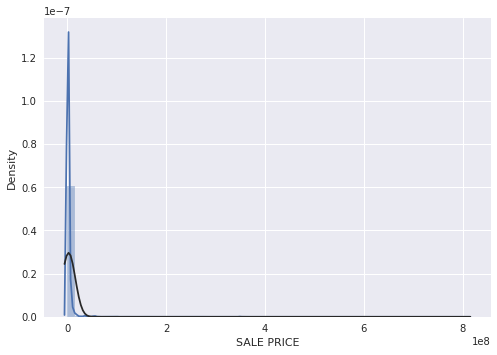

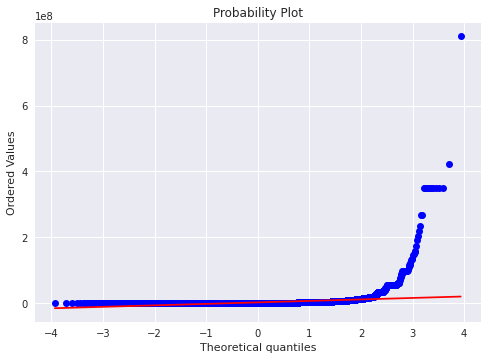

In [ ]:
# clean our target var
df_cat_transformed['SALE PRICE'] = df_cat_transformed['SALE PRICE'].apply(lambda x: int(re.sub(',', '',x)))
check_skewness(df_cat_transformed, 'SALE PRICE')

Our target is highly right skewed. We will remove some outliers but leave right skewed for now, but may apply log transform to make our target more normal before predictive modeling.


 mean = 1597464.34 and stddev = 1375615.40



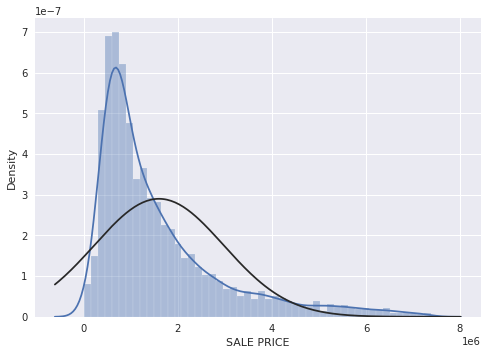

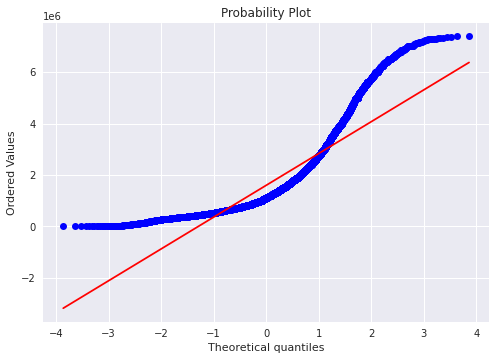

In [ ]:
# remove outliers and 0s, could do more here (including scaling), but will leave for now
df_cat_transformed = df_cat_transformed[df_cat_transformed['SALE PRICE'].between(10000, df_cat_transformed['SALE PRICE'].quantile(.95))]
check_skewness(df_cat_transformed, 'SALE PRICE')

#### Plot median daily sales price

Eventhough our target is highly right skewed, our median daily sales prices series looks approximately stationary, i.e. has constant mean and variance. This suggests that sale date has spurious relationship with sales price.

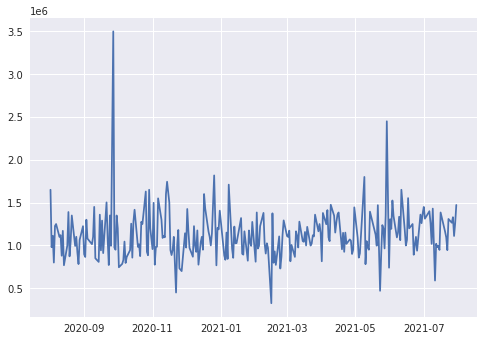

In [ ]:
median_price_series = df_cat_transformed.groupby('SALE DATE')['SALE PRICE'].agg(['median'])
df_cat_transformed.drop(['SALE DATE', 'SALE MONTH'], axis=1, inplace=True)
plt.plot(median_price_series)  

Look at features with highest pairwise correlations, no noteworthy relationships here. Also, notice we added our target for good measure, despite not being highly correlated with any features. 

We could run more meaningful independence/collinearity tests for ordinal and dummy data here (e.g. chi-squared test, mutual information test, etc.)

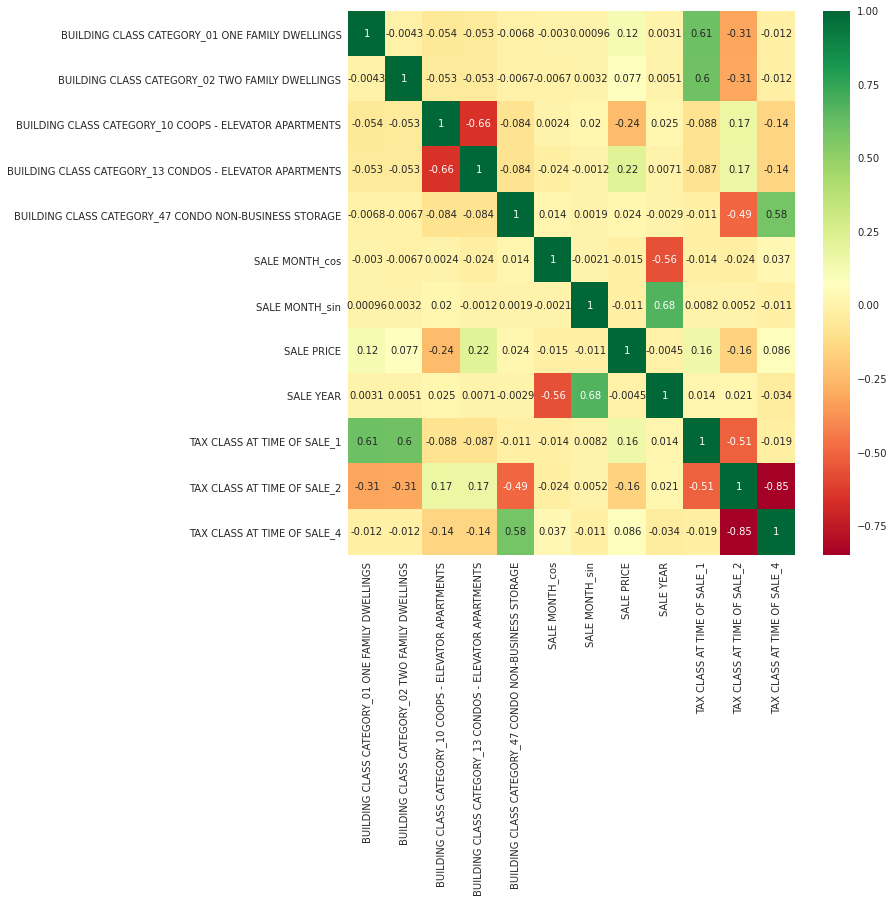

In [ ]:
corrmat = df_cat_transformed.corr()
top_corr_features = set()
for c in list(corrmat.index):
    top_corr_features.update(set(corrmat.index[abs(corrmat[c]).between(0.5,.99)])) 
        
top_corr_features.update({'SALE PRICE'})
plt.figure(figsize=(10,10))
g = sns.heatmap(df_cat_transformed[sorted(top_corr_features)].corr(),annot=True,cmap="RdYlGn")

We can see that we don't have strong correlation or linear relationships from the scatterplots below. Another good reason to look at more meaningful independence/collinearity tests for ordinal and dummy data (e.g. chi-squared test, mutual information test, etc.)

> Please excuse jupyter formatting!



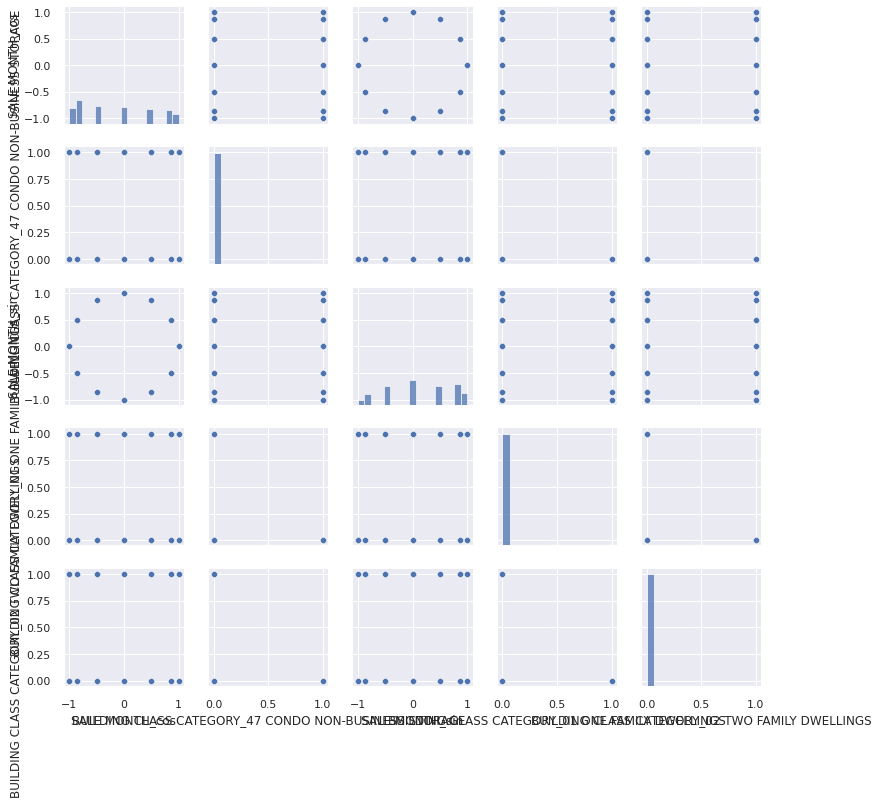

In [ ]:
sns.set()
cols = list(top_corr_features)[:5]
sns.pairplot(df_cat_transformed[cols])

---
## 2. Hypothesis Testing with Multiple Linear Regression¶
#### a. Null Hypothesis for t-test and f-test
---

In this section I run several hypothesis tests using MLR:

$\text{1. Full model F-Test:}$<br>
>${H}_{0} : {\ \beta}_{1} = {\beta}_{2} = {\beta}_{3} = ... = {\beta}_{m} = 0$
<br>
>${H}_{A} :$ At least one ${\ \beta}_{i}{\ \not=\ } 0 \text{  , for }\textit{i}\text{ in 1, 2, 3,..., m} $

Research question 1: Is a regression model containing at least one predictor useful in predicting the size of the sales price? In other words, is our full model useful at predicting sales price.<br> We will include predictors encoded from the following features : <code>['SALE PRICE', 'NEIGHBORHOOD', 'YEAR BUILT', 'SALE DATE', 'TAX CLASS AT TIME OF SALE','BUILDING CLASS CATEGORY']<code>
    
<br>




    
$\text{2. Full model T-Test:}$<br>
>${H}_{0} : {\ \beta}_{tax\_class_1} = 0$
<br>
>${H}_{A} : {\ \beta}_{tax\_class_1}{\ \not=\ } 0$

Research question 2: While controlling for all other features in our model, is the predictor 'TAX CLASS AT TIME OF SALE_1' in the full regression model significantly linearly related to the sales price? (Tax class 1: Includes most residential property of up to three units, vacant land that is zoned for residential use, and most condominiums that are not more than three stories.)
    
In other words, The t-test is a test for the marginal significance of the x1 predictor after controlling for all the rest of the full model predictor set.

---

---

### ***Hypothesis testing and regression output:***
---


### $\text{Full model F-Test:}$

In [ ]:
df_cat_transformed = df_cat_transformed.sample(frac=1, random_state=42)
df_cat_trans_small = df_cat_transformed[:].copy()

In [ ]:
# select columns described above in full model F-test
df_cat_transformed.drop(['TAX CLASS AT PRESENT', 'ZIP CODE',
                         'BUILDING CLASS AT TIME OF SALE','TAX CLASS AT PRESENT_na_flag', 
                         'BUILDING CLASS AT PRESENT_na_flag', 'BUILDING CLASS AT PRESENT', 
                         'NEIGHBORHOOD_ALPHABET CITY'
                         ],axis=1,inplace=True)

In [ ]:
X = df_cat_transformed.drop('SALE PRICE', axis=1)
X = sm.add_constant(X) # add intercept term
y = df_cat_transformed['SALE PRICE']

results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SALE PRICE   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     77.85
Date:                Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                        07:27:31   Log-Likelihood:            -1.8975e+05
No. Observations:               12337   AIC:                         3.796e+05
Df Residuals:                   12271   BIC:                         3.801e+05
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
const                                                      1.468e+06   1.09e+05     13.510      0.000    1.26e+06    1.68e+06
YEAR BUILT                                                 1075.1743    408.783      2.630      0.009     273.895    1876.454
SALE MONTH_sin                                            -2.406e+04   2.76e+04     -0.872      0.383   -7.82e+04       3e+04
SALE MONTH_cos                                            -2.292e+04   2.22e+04     -1.034      0.301   -6.64e+04    2.05e+04
SALE YEAR                                                  4.064e+04   4.84e+04      0.839      0.401   -5.43e+04    1.36e+05
YEAR BUILT_na_flag                                        -1.098e+05   4.56e+04     -2.410      0.016   -1.99e+05   -2.05e+04
NEIGHBORHOOD_CHELSEA                                        8.39e+05   1.26e+05      6.679      0.000    5.93e+05    1.09e+06
NEIGHBORHOOD_CHINATOWN                                      3.42e+05    2.1e+05      1.632      0.103   -6.87e+04    7.53e+05
NEIGHBORHOOD_CIVIC CENTER                                  1.601e+06   1.45e+05     11.010      0.000    1.32e+06    1.89e+06
NEIGHBORHOOD_CLINTON                                      -2.793e+04   1.42e+05     -0.196      0.844   -3.07e+05    2.51e+05
NEIGHBORHOOD_EAST VILLAGE                                  4.882e+05   1.54e+05      3.168      0.002    1.86e+05     7.9e+05
NEIGHBORHOOD_FASHION                                       3.739e+05   1.96e+05      1.907      0.057   -1.05e+04    7.58e+05
NEIGHBORHOOD_FINANCIAL                                    -4.054e+04   1.36e+05     -0.298      0.766   -3.07e+05    2.26e+05
NEIGHBORHOOD_FLATIRON                                      1.083e+06   1.43e+05      7.590      0.000    8.03e+05    1.36e+06
NEIGHBORHOOD_GRAMERCY                                      4.789e+05   1.31e+05      3.663      0.000    2.23e+05    7.35e+05
NEIGHBORHOOD_GREENWICH VILLAGE-CENTRAL                     1.016e+06   1.27e+05      7.981      0.000    7.67e+05    1.27e+06
NEIGHBORHOOD_GREENWICH VILLAGE-WEST                        1.091e+06   1.29e+05      8.492      0.000     8.4e+05    1.34e+06
NEIGHBORHOOD_HARLEM-CENTRAL                               -5.215e+05    1.3e+05     -4.017      0.000   -7.76e+05   -2.67e+05
NEIGHBORHOOD_HARLEM-EAST                                  -6.178e+05   1.64e+05     -3.771      0.000   -9.39e+05   -2.97e+05
NEIGHBORHOOD_HARLEM-UPPER                                 -5.423e+05   1.96e+05     -2.762      0.006   -9.27e+05   -1.57e+05
NEIGHBORHOOD_INWOOD                                        1.101e+04   1.75e+05      0.063      0.950   -3.31e+05    3.53e+05
NEIGHBORHOOD_JAVITS CENTER                                 

We see a very large F-test statistic and very small associate p-value in the regression output above (F-stat = 77.85, p-value = 0.00, with rounding).

The p-value is the probability — if the null hypothesis were true — that we would get an F-statistic larger than 77.85. 
 
Therefore, the probability that we would get an F-statistic larger than we observed is very close to 0. Assuming we have a significance level ${\alpha}$ = 0.05, there is sufficient evidence to reject the null hypothese and conclude that at least one of the ${\beta}$s in our full model is not equal to 0.

### $\text{Full model T-Test:}$

In the output 2 cells above, we see a very large t-test statistic and very small associate p-value in the regression output above (t-stat = 2.157, p-value = 0.0310, with rounding).

The probability that we would get a t-stat larger than we observed is very close to 0. Assuming we have a significance level ${\alpha}$ = 0.05, there is sufficient evidence to reject the null hypothese and conclude that _TAX CLASS 1_  has a significant relationship with sales price and the associatiad ${\beta}$s in our full model is not equal to 0.

<br>
<br>

---
## 3. Predictive modeling
---

In this section we will we take the following steps:
- establish baseline model
- comparision of supervised learning methods on small feature set
- denoising autoencoder to extract denoised features from latent repsentation of our original features
- comparison of models on denoised features
---

---

### ***a. Establish baseline model:***
---

Run unpenalized linear regression on small df to get baseline model loss to try to improve upon

In [ ]:
n_folds = 5

kfold = KFold(n_splits=n_folds, shuffle=False)
cv_results = np.sqrt(-cross_val_score(LinearRegression(), 
                                          X.values, 
                                          y, 
                                          cv=kfold, 
                                          scoring="neg_mean_squared_error"))

print("%s: %f (%f)" % ('BASELINE LR: ', cv_results.mean(), cv_results.std()))
# 1166561.158450 (10486.839846)

BASELINE LR: : 1166561.158450 (10486.839846)


---

### ***b. Comparision of machine learning models on small feature set:***
---

<br>
First, we will run several models and see which perform best with default hyperparameters.

In [ ]:
# models
models = []
models.append(('LR', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('AB', AdaBoostRegressor()))
models.append(('XGBR', XGBRegressor()))
models.append(('GBM', GradientBoostingRegressor(random_state = 5)))
models.append(('RF', RandomForestRegressor()))


# build dataframe
results = []
names = []
means = []
stddevs = []
n_folds = 5
for name, model in models:
    kfold = KFold(n_splits=n_folds, shuffle=False)
    cv_results = np.sqrt(-cross_val_score(model, 
                                          X.values, 
                                          y, 
                                          cv=kfold, 
                                          scoring="neg_mean_squared_error"))
    results.append(cv_results)
    means.append(cv_results.mean())
    stddevs.append(cv_results.std())
    names.append(name)
              
df_results = pd.DataFrame(np.array(results).T, columns = names)

[07:27:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:27:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



**Plot MSE of folds for each fitted ML model**

LR: 1166561.158450 (11724.643383)
Lasso: 1166560.268920 (11724.028444)
AB: 1328156.285029 (29561.547481)
XGBR: 1121726.867097 (11113.890558)
GBM: 1121708.064774 (9642.460553)
RF: 1085160.041945 (23414.612450)


Text(0, 0.5, 'mean squared error')

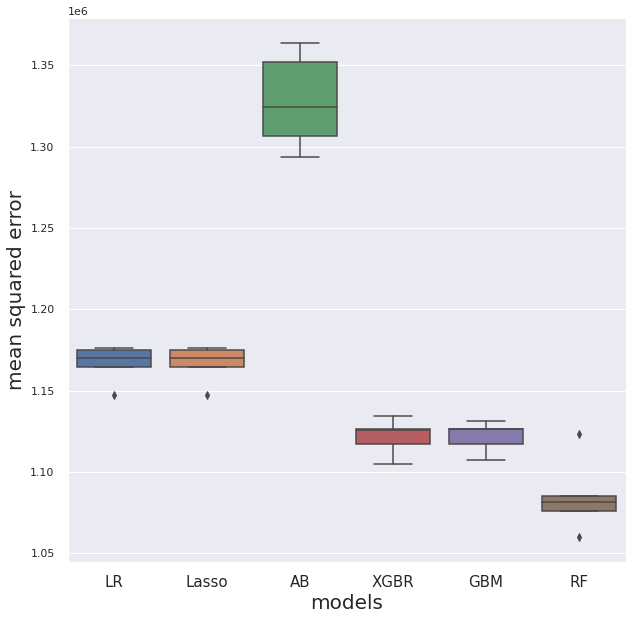

In [ ]:
# print mean and stddev root mean squared error from 10 fold 
for col in df_results:
    print("%s: %f (%f)" % (col, df_results[col].mean(), df_results[col].std()))

fig, ax = plt.subplots(figsize=(10,10))
fig = sns.boxplot(data=df_results)
fig = fig.set_xticklabels(labels = df_results.columns,fontdict={'fontsize':15})
ax.set_xlabel('models', size = 20)
ax.set_ylabel('mean squared error', size = 20)


Random forest, on average, seems to perform the best out of all of our models before tuning. Several of these models out perform our basline model by a large margin, which supports our hypothesis of model complexity and features improving upon our baseline model performance.

---

### ***c. Clean features for medium feature set:***
---

<br>
First, we will run several models and see which perform best with default hyperparameters.

Create df with previously dropped nominal features (nom_feats_medium). Then we impute and encode new vars

In [ ]:
medium_df = df_cat_trans_small[:].copy()

In [ ]:
nom_feats_medium = ['ZIP CODE', 'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT', 'BUILDING CLASS AT TIME OF SALE']
for c in nom_feats_medium:
    num = medium_df[c].mode()[0]
    medium_df[c].fillna(num, inplace = True)
    medium_df.loc[medium_df[c].value_counts()[medium_df[c]].values < 50, c] = "RARE_VALUE"

cat_feats_med = CategoricalFeatures(medium_df, 
                                nominal_features = nom_feats_medium,
                                ordinal_features = [], 
                                encoding_type="ohe",
                                handle_na=True)
df_cat_trans_med = cat_feats_med._fit_transform()

In [ ]:
X_medium = df_cat_trans_med.drop('SALE PRICE',axis=1)
y_medium = df_cat_trans_med['SALE PRICE']

In [ ]:
# models
models = []
models.append(('XGBR', XGBRegressor()))
models.append(('RF', RandomForestRegressor()))

# build dataframe
results = []
names = []
means = []
stddevs = []
n_folds = 3
for name, model in models:
    kfold = KFold(n_splits=n_folds, shuffle=False)
    cv_results = np.sqrt(-cross_val_score(model, 
                                          X_medium.values, 
                                          y_medium, 
                                          cv=kfold, 
                                          scoring="neg_mean_squared_error"))
    results.append(cv_results)
    means.append(cv_results.mean())
    stddevs.append(cv_results.std())
    names.append(name)
              
df_results = pd.DataFrame(np.array(results).T, columns = names)

[07:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:28:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:28:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBR: 1098027.392121 (20543.130451)
RF: 1071618.125450 (5285.467157)


Text(0, 0.5, 'mean squared error')

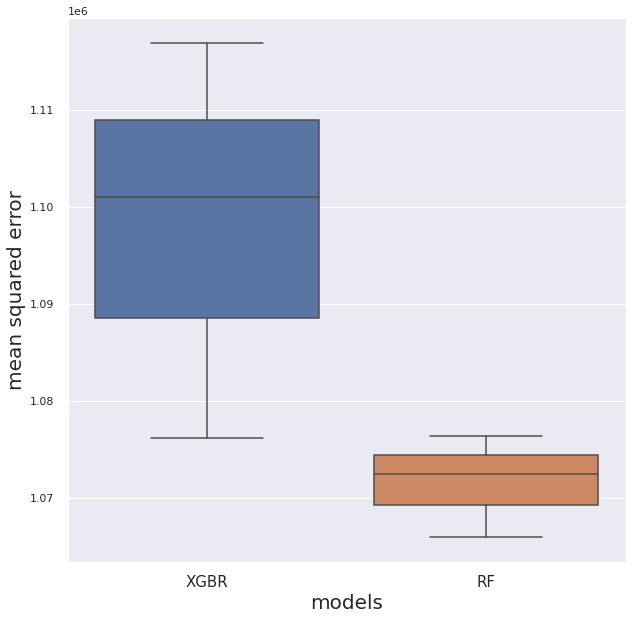

In [ ]:
# print mean and stddev root mean squared error from 10 fold 
for col in df_results:
    print("%s: %f (%f)" % (col, df_results[col].mean(), df_results[col].std()))

fig, ax = plt.subplots(figsize=(10,10))
fig = sns.boxplot(data=df_results)
fig = fig.set_xticklabels(labels = df_results.columns,fontdict={'fontsize':15})
ax.set_xlabel('models', size = 20)
ax.set_ylabel('mean squared error', size = 20)




---
#### ***d. Comparision of supervised machine learning models on medium feature set:***
---
For Random Forest, our best performing model, we'll do a gridsearch of a hyperparameter dictionary and find the best performing hyperparameter combination

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {'n_estimators' : [300, 600, 900], 'max_depth': [10, 30, None], 'min_samples_split':[2, 10, 30], 'min_samples_leaf':[2,5,10]}
grid = RandomizedSearchCV(estimator = RandomForestRegressor(random_state = 5),
                    param_distributions = param_grid, 
                    n_iter = 5,
                    scoring = 'neg_mean_squared_error', 
                    cv = 2, 
                    n_jobs = -1)

# %%capture
grid_result = grid.fit(X_medium.values, y_medium)

print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))
means = np.sqrt(-grid_result.cv_results_['mean_test_score'])
params = grid_result.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

Best: 1051980.112099 using {'n_estimators': 300, 'min_samples_split': 30, 'min_samples_leaf': 2, 'max_depth': 30}
1060143.584102 with: {'n_estimators': 900, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
1051980.112099 with: {'n_estimators': 300, 'min_samples_split': 30, 'min_samples_leaf': 2, 'max_depth': 30}
1082465.251407 with: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_depth': 30}
1087120.279290 with: {'n_estimators': 900, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}
1060670.215454 with: {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': None}


---


### ***e. Supervised neural network prediction:***

---
<br>

In this section we optimize our neural network model by training a range od network over the parameter and hyperparameter space.

Below we define classes and helper functions to help train (i.e. minimize RMSE with respect to network weights) a range of networks over the network topology parameters (i.e. layers, number of nodes, regularization, etc.) and hyperparamaters (i.e. learning rate, optimizer, epochs, etc.).



In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    sampler = optuna.samplers.RandomSampler(seed)
    
seed_everything(seed=42)

In [ ]:
# data set class
class Dataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, item):
        return {
            "x": torch.tensor(self.features[item, :], dtype=torch.float),
            "y": torch.tensor(self.targets[item], dtype=torch.float),
        }

In [ ]:
# function to optimize neural nets
def define_model(trial, param_ranges_dict):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    # n_layers = trial.suggest_int("n_layers", 1, 3)
    # batch_norm = trial.suggest_int("batch_norm", 0, 1)  
    batch_norm = 0
    n_layers = sum('n_units' in s for s in list(param_ranges_dict.keys()))
    layers = []
    in_features = len(feature_columns) - 1

 
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i),
                                         param_ranges_dict[f'n_units_l{i}'][0], 
                                         param_ranges_dict[f'n_units_l{i}'][1])

        layers.append(nn.Linear(in_features, out_features))      
        
        if batch_norm:
            layers.append(nn.BatchNorm1d(out_features))
            
        layers.append(nn.ReLU())
        # layers.append(nn.Dropout(p))
        in_features = out_features
    layers.append(nn.Linear(in_features, 1))    

    return nn.Sequential(*layers)

In [ ]:
# class to hold training loops, and loss and noise functions
class Engine:
    def __init__(self, model, optimizer, device):
        self.model = model
        self.optimizer = optimizer
        self.device = device
    
    # statis cause not using anything from init
    @staticmethod
    def loss_fn(outputs, targets):
        targets = targets.unsqueeze(1)
        assert outputs.size() == targets.size()
        assert torch.is_tensor(outputs) == torch.is_tensor(targets)
        
        criterion = nn.MSELoss()              
        return torch.sqrt(torch.mean((outputs - targets)**2))
    
    @staticmethod
    def swap_noise(inputs, swap_noise_p =.15):      
        batch_size, n_features = inputs.size()[0], inputs.size()[1]
        idx = range(batch_size)
        n_rows_swap = int(round(batch_size * swap_noise_p))
        inputs = inputs.numpy()

        for feature_ind in range(n_features):
            
            # shuffle column to sample from
            sampling_feature = np.random.permutation(inputs[:, feature_ind])
            
            # randomly select indices to swap
            swap_idx = np.random.choice(idx, size=n_rows_swap)
            
            # replacing column wise values from sampled column
            inputs[swap_idx, feature_ind] = np.random.choice(sampling_feature, size=n_rows_swap)
            
        return torch.from_numpy(inputs)

    def train(self, data_loader):
        self.model.train()
        final_loss = 0
        for data in data_loader:    
            self.optimizer.zero_grad()   
            inputs = data["x"].to(self.device)
            targets = data["y"].to(self.device)
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets)                       
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()
            
        return final_loss / len(data_loader)

    def dae_train(self, data_loader):
        self.model.train()
        final_loss = 0
        for data in data_loader:    
            self.optimizer.zero_grad()   
            targets = data["x"].to(self.device) 
            aug_inputs = self.swap_noise(data["x"], .15).to(self.device) 
            outputs = self.model(aug_inputs)
            loss = nn.MSELoss()(outputs, targets)                  
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()
        return final_loss / len(data_loader)

    def evaluate(self, data_loader):
        self.model.eval()
        final_loss = 0
        for data in data_loader:
            inputs = data["x"].to(self.device)
            targets = data["y"].to(self.device)
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets)
            final_loss += loss.item()
        return final_loss / len(data_loader)

    @staticmethod
    def plot_learn_curves(epoch_losses, time_stamp):
        plt.ioff()
        fig = plt.figure()
        plt.style.use('seaborn')
        plt.xlabel('Epochs')
        plt.ylabel('MSE')
        plt.title(f'Learning curves - {time_stamp}')
        plt.plot(epoch_losses)
        plt.savefig(f'{config_dae.PLOT_PATH}{script_name}_LC_{time_stamp}.png')
        plt.close(fig)


<br>

---

---

### ***Define objective function:***
Our objective function below is a training loop that fits the entire dataset to our model over 1000 epochs or until we overfit invoke early stopping.
<br><br>
In addition, this objective function can be repeatedly ran with different network topology parameters and hyperparameters to optimize our network topology. We use the optimization package 'optuna' to optimize this objective function over the parameter and hyperparameter space containing the following dimension: `number of network layers, number of layer nodes, dropout, batch normalization, optimizer, and learning rate.`
<br>

---

In [ ]:
def objective(trial, 
              param_ranges_dict,
              save_model = False, 
              plot_learning_curves = False
             ):  
    
    objective_start_time = f'{datetime.datetime.now().strftime("%Y%m%d %H:%M:%S")}'
    
    print(f"TRIAL {len(study.trials)} START TIME: {objective_start_time}\n")
    
    #------- RUN TRAINING LOOP ----------
    total_loss = 0
    fold_losses = []
    epoch_losses_by_fold = []

    for fold in range(5):
        train_df = train[train.kfold != fold].reset_index(drop=True)
        valid_df = train[train.kfold == fold].reset_index(drop=True)

        x_train = train_df[feature_columns].drop('kfold', axis=1).to_numpy()
        y_train = train_df[target_columns].to_numpy()

        x_valid = valid_df[feature_columns].drop('kfold', axis=1).to_numpy()
        y_valid = valid_df[target_columns].to_numpy()

        train_dataset = Dataset(features=x_train, targets=y_train)
        valid_dataset = Dataset(features=x_valid, targets=y_valid)

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=64, num_workers=4, shuffle=True
        )

        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=64, num_workers=4
        )
        
        # instantiate the model.
        model = define_model(trial, param_ranges_dict).to(DEVICE)

        # Generate the learning rate and optimizer
        lr = trial.suggest_float("lr", param_ranges_dict['lr'][0], param_ranges_dict['lr'][1], log=True)        
        optimizer_name = 'Adam'
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

        # Print trial parameters        
        if fold == 0:
            print(f"OPTIMIZER:\n{optimizer}\n")
            
            current_trial = study.trials[len(study.trials) - 1]
            print(f"CURRENT TRIAL PARAMETERS: ")    
            for key, value in current_trial.params.items():
                print("    {}: {}".format(key, value))
            print("\n")
        
        # Training of the model.
        eng = Engine(model, optimizer, device=DEVICE)

        best_loss = np.inf
        early_stopping_iter = 10
        early_stopping_counter = 0 
        
        epoch_losses = []
        for epoch in range(EPOCHS):
            
            train_loss = eng.train(train_loader)
            valid_loss = eng.evaluate(valid_loader)         
  
            if (epoch % 10 == 0) or (early_stopping_counter >= 25):
                print(
                    f"FOLD: {fold} -- EPOCH: {epoch:.0f} -- TRAIN RMSE LOSS: {train_loss:.4f} -- "
                    f"VALID RMSE LOSS: {valid_loss:.4f} -- {datetime.datetime.now().strftime('%Y%m%d%H:%M:%S')}" 
                )

            if valid_loss < best_loss:
                best_loss = valid_loss
                early_stopping_counter = 0
                if save_model:
                    torch.save(model.state_dict(), f"models/nn_{trial.number}_{objective_start_time}.bin")
            else:
                early_stopping_counter += 1

            if early_stopping_counter > early_stopping_iter:
                break
        
        print(
            f"FOLD: {fold} ----- BEST VALID RMSE LOSS: {best_loss} ----- "
            f"{datetime.datetime.now().strftime('%Y%m%d %H:%M:%S')}\n"
        )

        fold_losses.append(best_loss)
        total_loss += best_loss
    

    # total cv loss
    CV_loss = total_loss/5
    print('FOLDS:')
    print(f" FOLD 0: {fold_losses[0]:.5f}")
    print(f" FOLD 1: {fold_losses[1]:.5f}")
    print(f" FOLD 2: {fold_losses[2]:.5f}")
    print(f" FOLD 3: {fold_losses[3]:.5f}")
    print(f" FOLD 4: {fold_losses[4]:.5f}\n")
    
    print(f"CROSS VALIDATION SCORE: ")
    print(f" {CV_loss:.10f} ----- {datetime.datetime.now().strftime('%Y%m%d %H:%M')}\n")  
    
    if len(study.trials) > 1:
        print("**************")
        print("Best CV trial:")
        best_trial_temp = study.best_trial

        print(f"  Value:  {best_trial_temp.value}\n")
        print("  Params: ")
        for key, value in trial.params.items():
            print("    {}: {}".format(key, value))
        print("**************\n")
    print(f"{100*'#'}\n")
        
    trials_df = study.trials_dataframe()
    trials_df.to_csv(f'logs/nn_trials_{study_start_time}.csv')

    return CV_loss


#### ***Assign folds for neural network training:***
---

In [ ]:
df_cat_trans_med["kfold"] = -1
df_cat_trans_med = df_cat_trans_med.reset_index(drop=True)
kf = KFold(n_splits=5, shuffle=False)

for fold, (train_idx, val_idx) in enumerate(kf.split(X=df_cat_trans_med, y=df_cat_trans_med['SALE PRICE'].values)):
    df_cat_trans_med.loc[val_idx, 'kfold'] = fold

feature_columns =  list(X_medium.columns) + ['kfold']
target_columns = y_medium.name

train = df_cat_trans_med[:].copy()
train.kfold.value_counts()

1    2468
0    2468
4    2467
3    2467
2    2467
Name: kfold, dtype: int64

#### ***Start optimization of RMSE with respect to network topology space:***
---

In [ ]:
# dictionary for network parameters
optuna_params_dict = {'lr': [.0005, .005],
                      
                      'n_units_l0': [220, 300],
                      'n_units_l1': [170, 240],
                      'n_units_l2': [120, 180],
                      'n_units_l3': [100, 130],
                      'n_units_l4': [70, 100],
                      'n_units_l5': [50, 80],
                      'n_units_l6': [20, 40]}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 1000

if __name__ == "__main__":  
    study_start_time = f'{datetime.datetime.now().strftime("%Y%m%d %H:%M")}'
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, optuna_params_dict, save_model=False), n_trials=5)

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials), "\n")

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    trials_df = study.trials_dataframe()
    print(f"\n\n\nTRIALS DATAFRAME: ")
    print(trials_df)

    joblib.dump(study,f'logs/nn_study_{study_start_time}.pkl')

TRIAL 1 START TIME: 20210917 07:30:18

OPTIMIZER:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0015204848997598679
    weight_decay: 0
)

CURRENT TRIAL PARAMETERS: 
    n_units_l0: 268
    n_units_l1: 184
    n_units_l2: 140
    n_units_l3: 101
    n_units_l4: 91
    n_units_l5: 63
    n_units_l6: 35
    lr: 0.0015204848997598679


FOLD: 0 -- EPOCH: 0 -- TRAIN RMSE LOSS: 1671297.0206 -- VALID RMSE LOSS: 1432168.6202 -- 2021091707:30:22
FOLD: 0 -- EPOCH: 10 -- TRAIN RMSE LOSS: 1080424.5948 -- VALID RMSE LOSS: 1099620.4183 -- 2021091707:30:31
FOLD: 0 -- EPOCH: 20 -- TRAIN RMSE LOSS: 1053651.5440 -- VALID RMSE LOSS: 1090141.0865 -- 2021091707:30:41
FOLD: 0 -- EPOCH: 30 -- TRAIN RMSE LOSS: 1020056.1194 -- VALID RMSE LOSS: 1075906.6138 -- 2021091707:30:52
FOLD: 0 -- EPOCH: 40 -- TRAIN RMSE LOSS: 989909.1512 -- VALID RMSE LOSS: 1083910.3750 -- 2021091707:31:02
FOLD: 0 ----- BEST VALID RMSE LOSS: 1075207.3173076923 ----- 20210917 07:31:11

FOLD:

In [ ]:
pd.read_csv(f'logs/nn_trials_{study_start_time}.csv').sort_values('value').iloc[0]


Unnamed: 0                                    0
number                                        0
value                               1.05575e+06
datetime_start       2021-09-17 07:30:18.814872
datetime_complete    2021-09-17 07:35:27.285505
duration                 0 days 00:05:08.470633
params_lr                            0.00152048
params_n_units_l0                           268
params_n_units_l1                           184
params_n_units_l2                           140
params_n_units_l3                           101
params_n_units_l4                            91
params_n_units_l5                            63
params_n_units_l6                            35
state                                  COMPLETE
Name: 0, dtype: object

---
#### ***Neural network optimization study complete***
---

Above we see one of our best NN trials on the full feature set, the RMSE CV is an improvement upon our grid search Random Forest in the last section. 
<br>

However, this improvement is marginal (from ~1.07e6 to ~1.05e6) and clearly requires more involved modeling process and is less interpretable than Random Forest or our other baseline models. Also, we should check carefully the relationship between train and test loss, to make sure we are not over fitting. Setting aside a completely untouched holdout set to test our cross validated model would also be a good precaution to take.<br><br>
Below we have graphics of our model optimization study. These plots help us understand what parameters are most important in our network topology optimzation study. As you can see, our the first trial turned out to have the best parameters of our study, although this would likely change if we increase the number of trials.

In [ ]:
# study = joblib.load(f'logs/nn_study_{study_start_time}.pkl')
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_slice(study)



---


### ***f. Denoising Autoencoder optimizaton for latent feature engineering***

---
In this next section we use denoising autoencoders to learn a large set of generalized or denoised features that capture more sophisticated interactions.<br><br>
Denoising autoencoders are more popular for computer vision tasks, yet we use the swap noise algorithm (defined in Engine class) to inject noise into our taular data. Swap noise randomly picks a proportion of cells in our dataframe and replaces their values with values from randomly sampled rows in the same column.
<br><br>
We will start by defining necessary classes and functions to optimisize DAE network topology (as we did we NN earlier), next we use the DAE on our entire feature set, and finally we train a new NN to see if we improve upon previous benchmarks.

---



In [ ]:
def define_dae(trial, param_ranges_dict):
    # We optimize the number of layers, hidden units, and noise ratio in each layer.
    layers = []
    n_layers = trial.suggest_int("n_layers", 
                                 param_ranges_dict[f'n_layers'][0],
                                 param_ranges_dict[f'n_layers'][1],
                                 param_ranges_dict[f'n_layers'][2])
    
    out_features_mult = trial.suggest_int("out_features_mult", 
                                          param_ranges_dict[f'out_features_mult'][0], 
                                          param_ranges_dict[f'out_features_mult'][1],  
                                          param_ranges_dict[f'out_features_mult'][2])
    
    in_features = len(feature_columns) - 1  
    batch_norm = trial.suggest_int('batch_norm',
                                   param_ranges_dict['batch_norm'][0],
                                   param_ranges_dict['batch_norm'][1])
    
    out_features = in_features * out_features_mult
    for i in range(n_layers):
        layers.append(nn.Linear(in_features, out_features))
        if batch_norm:
            layers.append(nn.BatchNorm1d(out_features))
            
        layers.append(nn.ReLU())
        in_features = out_features
    layers.append(nn.Linear(in_features, len(feature_columns) - 1))    

    return nn.Sequential(*layers)
    

In [ ]:
def dae_objective(trial, 
              param_ranges_dict,
              save_model, 
              plot_learning_curves = False
             ):  
    
    # create time stamp
    objective_start_time = f'{datetime.datetime.now().strftime("%Y%m%d %H:%M")}'
    print(f"TRIAL {len(study.trials)} START TIME: {objective_start_time}\n")
    
    # set up data and instantiate data loader
    x_train = train[feature_columns].drop('kfold', axis=1).to_numpy()

    train_dataset = Dataset(features=x_train, targets=x_train)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64, num_workers=4, shuffle=True
    )

    # instantiate the model.
    model = define_dae(trial, param_ranges_dict).to(DEVICE)
    print(model)

    # generate the learning rate and optimizer
    lr = trial.suggest_float("lr", param_ranges_dict['lr'][0], param_ranges_dict['lr'][1], log=True)        
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    
    # Print trial parameters        
    print(f"OPTIMIZER:\n{optimizer}\n")
    current_trial = study.trials[len(study.trials) - 1]
    print(f"CURRENT TRIAL PARAMETERS: ")    
    for key, value in current_trial.params.items():
        print("    {}: {}".format(key, value))
    print("\n")

    # Training of the model.
    eng = Engine(model, optimizer, device=DEVICE)
    best_loss = np.inf
    early_stopping_iter = 10
    early_stopping_counter = 0 

    # loop through epochs with early stopping to avoid overfitting
    for epoch in range(EPOCHS):
        train_loss = eng.dae_train(train_loader)                  

        if (epoch % 5 == 0) or (early_stopping_counter >= 15):
            print(
                f"EPOCH: {epoch:.0f} -- RECONSTUCTION BCE LOSS: {train_loss:.4f} -- "
                f"{datetime.datetime.now().strftime('%Y%m%d %H:%M:%S')}" 
            )

        # check if we have improvef on loss
        if train_loss < best_loss:
            best_loss = train_loss
            early_stopping_counter = 0
            if save_model:
                torch.save(model.state_dict(), f"models/dae_{trial.number}_{study_start_time}.bin")
        else:
            early_stopping_counter += 1

        if early_stopping_counter > early_stopping_iter:
            break

    # print final loss
    print(
        f"RECONSTUCTION BCE LOSS: {best_loss:.5f} ----- "
        f"{datetime.datetime.now().strftime('%Y%m%d %H:%M:%S')}\n"
    )
    
    # format and print output
    if len(study.trials) > 1:
        print("**************")
        print("Best trial:")
        best_trial_temp = study.best_trial

        print(f"  Value:  {best_trial_temp.value}\n")
        print("  Params: ")
        for key, value in trial.params.items():
            print("    {}: {}".format(key, value))
        print("**************\n")
    print(f"{100*'#'}\n")
        
    # log performance
    trials_df = study.trials_dataframe()
    trials_df.to_csv(f'logs/dae_trials_{study_start_time}.csv')
    
    return best_loss

#### ***Start optimization study of denoising autoencoder with respect to network topology space:***
---

In [ ]:
optuna_params_dict =  {'lr': [.0001, 1e-3],     
                      'batch_norm': [0, 1],
                      'out_features_mult': [5, 10, 1],
                      'n_layers': [3, 5, 1],
                        'batch_size': [0]
                       }

if __name__ == "__main__":
    study_start_time = f'{datetime.datetime.now().strftime("%Y%m%d %H:%M")}'
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: 
                   dae_objective(trial,
                                 param_ranges_dict=optuna_params_dict,
                                 save_model = True, 
                                 plot_learning_curves = False), n_trials=5)

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials), "\n")

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    trials_df = study.trials_dataframe()
    print(f"\n\n\nTRIALS DATAFRAME: ")
    print(trials_df)
    
    trials_df.to_csv(f'logs/dae_trials_{study_start_time}.csv')
    joblib.dump(study,f'logs/dae_study_{study_start_time}.pkl')

TRIAL 1 START TIME: 20210917 07:59

Sequential(
  (0): Linear(in_features=135, out_features=945, bias=True)
  (1): BatchNorm1d(945, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=945, out_features=945, bias=True)
  (4): BatchNorm1d(945, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=945, out_features=945, bias=True)
  (7): BatchNorm1d(945, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=945, out_features=945, bias=True)
  (10): BatchNorm1d(945, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=945, out_features=945, bias=True)
  (13): BatchNorm1d(945, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): Linear(in_features=945, out_features=135, bias=True)
)
OPTIMIZER:
RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False

In [ ]:
pd.read_csv(f'logs/dae_trials_{study_start_time}.csv').sort_values('value').iloc[0]


Unnamed: 0                                           0
number                                               0
value                                          1.59277
datetime_start              2021-09-17 07:59:25.876168
datetime_complete           2021-09-17 08:02:37.496186
duration                        0 days 00:03:11.620018
params_batch_norm                                    1
params_lr                                  0.000495984
params_n_layers                                      5
params_out_features_mult                             7
state                                         COMPLETE
Name: 0, dtype: object

---
### ***Denoising autoencoder optimization study complete***
---

Above we see one of our best dae trials on the full feature set. This model produces a denoised, more general version of our features that is most similar to our original input. Now that we have the trained model, we can extract the activations from our entire sample as our new feature set in the next section.

Below we have graphics of our model optimization study. These plots help us understand what parameters are most important in our network topology optimzation study.


In [ ]:
# study = joblib.load(f'logs/dae_study_{study_start_time}.pkl')
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_slice(study)

---

### ***g. Denoising Autoencoder latent feature extraction***
In this section we pass our sample through our trained denoising autoencoder and grab the activations from a middle layer. We will then use these features as a new, more generalized feature set to predict our target.

---

In [ ]:
def DAE(dae_best_params):
    # We optimize the number of layers, hidden units, and noise ratio in each layer.
    layers = []

    n_layers = dae_best_params[f'n_layers']
    
    out_features_mult = dae_best_params[f'out_features_mult']
    
    in_features = len(feature_columns) - 1  

    batch_norm = dae_best_params['batch_norm']
                                  
    out_features = in_features * out_features_mult
    
    for i in range(n_layers):
        layers.append(nn.Linear(in_features, out_features))
        if batch_norm:
            layers.append(nn.BatchNorm1d(out_features))
            
        layers.append(nn.ReLU())
        in_features = out_features
    layers.append(nn.Linear(in_features, len(feature_columns) - 1))    

    return nn.Sequential(*layers)


---
### Get best model parameters from optuna study
---

In [ ]:
dae_best_params_df = pd.read_csv(f'logs/dae_trials_{study_start_time}.csv').sort_values('value').iloc[0]
dae_best_params_df

Unnamed: 0                                           0
number                                               0
value                                          1.59277
datetime_start              2021-09-17 07:59:25.876168
datetime_complete           2021-09-17 08:02:37.496186
duration                        0 days 00:03:11.620018
params_batch_norm                                    1
params_lr                                  0.000495984
params_n_layers                                      5
params_out_features_mult                             7
state                                         COMPLETE
Name: 0, dtype: object

In [ ]:
dae_params = dae_best_params_df[dae_best_params_df.index.map(lambda x: x in ['params_n_layers','params_out_features_mult','params_batch_norm'])]
dae_best_params = {f"{i[7:]}":dae_params[i]  for i in dae_params.index}
dae_best_params

{'batch_norm': 1, 'n_layers': 5, 'out_features_mult': 7}

---
### Instantiate denoising autocoder with weights from best trained dae
---

In [ ]:
model = DAE(dae_best_params)
model.load_state_dict(torch.load(f'models/dae_{dae_best_params_df["number"]}_{study_start_time}.bin'))
model.to(DEVICE)
model

Sequential(
  (0): Linear(in_features=135, out_features=945, bias=True)
  (1): BatchNorm1d(945, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=945, out_features=945, bias=True)
  (4): BatchNorm1d(945, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=945, out_features=945, bias=True)
  (7): BatchNorm1d(945, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=945, out_features=945, bias=True)
  (10): BatchNorm1d(945, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=945, out_features=945, bias=True)
  (13): BatchNorm1d(945, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): Linear(in_features=945, out_features=135, bias=True)
)

In [ ]:
# set up data and instantiate data loader
x_train = train[feature_columns].to_numpy()
y_train = train[[target_columns]+['kfold']].to_numpy()

train_dataset = Dataset(features=x_train, targets=y_train)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, num_workers=4,
)

In [ ]:
# a dict to store the activations
activation = {}
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

In [ ]:
# grabbing layers
dae_n_layers = dae_best_params_df['params_n_layers']
if dae_best_params['batch_norm']:
    activation_1 = str(3*dae_n_layers - 4)
    activation_2 = str(3*dae_n_layers - 1)
else:
    activation_1 = str(2*dae_n_layers - 3)
    activation_2 = str(2*dae_n_layers - 1)
print(f'grabbing layers: {activation_1}, {activation_2}')

grabbing layers: 11, 14


In [ ]:
# register forward hooks on the layers of choice
h1 = model._modules[activation_1].register_forward_hook(getActivation(activation_1))
h2 = model._modules[activation_2].register_forward_hook(getActivation(activation_2))

In [ ]:
relu_output_1, relu_output_2, dae_targets_b = [], [], []

# go through all the batches in the dataset
for i, batch in enumerate(train_loader):

  # forward pass -- getting the outputs
  inputs = batch["x"].to(DEVICE)
  outputs = model(inputs)
  targets = batch["y"][:, 0]
  # collect the activations in the correct list
  relu_output_1.append(activation[activation_1])
  relu_output_2.append(activation[activation_2])
  dae_targets_b.append(batch["y"])

# detach the hooks
h1.remove()
h2.remove()

# stack batches from two layers and average
dae_layer_outputs_1 = torch.cat(relu_output_1)
dae_layer_outputs_2 = torch.cat(relu_output_2)
dae_targets = torch.cat(dae_targets_b).detach().numpy()
dae_lat_feats_arr = torch.mean(torch.stack((dae_layer_outputs_1, dae_layer_outputs_2)), 0).cpu().detach().numpy()

# create new df with dae features and target
dae_feats_dict = {f'dae_{i+1}':dae_lat_feats_arr[:,i] for i in range(len(dae_lat_feats_arr[0,:]))}
dae_feats_dict['SALE PRICE'] = dae_targets[:,0].astype(int)
dae_feats_dict['kfold'] = dae_targets[:,1].astype(int)
dae_latent_features = pd.DataFrame(dae_feats_dict)

In [ ]:
# make sure our latent features are right size
assert (dae_latent_features['SALE PRICE'] == train['SALE PRICE']).sum()
assert (dae_latent_features['kfold'] == train['kfold']).sum()
assert len(dae_latent_features) == len(train)



---


### ***h. Neural network prediction of denoised features***
In this section we take the denoised feature set and predict our target using an optimized neural network.

---

In [ ]:
# dictionary for network parameters
optuna_params_dict = {'lr': [.001, .01],
                      
                      'n_units_l0': [1000, 1400],
                      'n_units_l1': [700, 1100],
                      'n_units_l2': [500, 800],
                      'n_units_l3': [300, 600],
                      'n_units_l4': [150, 300],
                      'n_units_l5': [80, 170],
                      'n_units_l6': [40, 90]}

train = dae_latent_features[:].copy()
feature_columns, target_columns = list(train.columns)[:-2] + ['kfold'], 'SALE PRICE' 

if __name__ == "__main__":  
    study_start_time = f'{datetime.datetime.now().strftime("%Y%m%d %H:%M")}'
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, optuna_params_dict, save_model=True), n_trials=3)

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials), "\n")

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    trials_df = study.trials_dataframe()
    print(f"\n\n\nTRIALS DATAFRAME: ")
    print(trials_df)

    joblib.dump(study,f'logs/nn_denoised_study_{study_start_time}.pkl')

TRIAL 1 START TIME: 20210917 08:10:32

OPTIMIZER:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0052611474876494676
    weight_decay: 0
)

CURRENT TRIAL PARAMETERS: 
    n_units_l0: 1162
    n_units_l1: 756
    n_units_l2: 552
    n_units_l3: 528
    n_units_l4: 174
    n_units_l5: 92
    n_units_l6: 86
    lr: 0.0052611474876494676


FOLD: 0 -- EPOCH: 0 -- TRAIN RMSE LOSS: 1365461.5617 -- VALID RMSE LOSS: 1286491.1426 -- 2021091708:10:33
FOLD: 0 -- EPOCH: 10 -- TRAIN RMSE LOSS: 1290230.6484 -- VALID RMSE LOSS: 1396169.6186 -- 2021091708:10:47
FOLD: 0 ----- BEST VALID RMSE LOSS: 1257228.766025641 ----- 20210917 08:10:59

FOLD: 1 -- EPOCH: 0 -- TRAIN RMSE LOSS: 1405216.1790 -- VALID RMSE LOSS: 1259719.9087 -- 2021091708:11:00
FOLD: 1 -- EPOCH: 10 -- TRAIN RMSE LOSS: 1280848.9016 -- VALID RMSE LOSS: 1245273.7340 -- 2021091708:11:14
FOLD: 1 -- EPOCH: 20 -- TRAIN RMSE LOSS: 1278581.1976 -- VALID RMSE LOSS: 1237483.0946 -- 2021091708:11:27
FOLD

In [ ]:
pd.read_csv(f'logs/nn_trials_{study_start_time}.csv').sort_values('value').iloc[0]


Unnamed: 0                                    1
number                                        1
value                               1.25121e+06
datetime_start       2021-09-17 08:14:58.357119
datetime_complete    2021-09-17 08:20:01.439047
duration                 0 days 00:05:03.081928
params_lr                            0.00215138
params_n_units_l0                          1227
params_n_units_l1                           888
params_n_units_l2                           637
params_n_units_l3                           320
params_n_units_l4                           254
params_n_units_l5                            90
params_n_units_l6                            90
state                                  COMPLETE
Name: 1, dtype: object

---
### ***Neural network on denoised features study complete***
---

Above we see results from best neural network prediction trial on the denoised features. This model produces the best nn on the denoised latent feature set. The RMSE from this model didn't surpass our best model (neural network on full feature set), but could maybe be improved with more tinkering to the swap noise algorithm we used to add noise.

Below we have graphics of our model optimization study. These plots help us understand what parameters are most important in our network topology optimzation study.

In [ ]:
# study = joblib.load(f'logs/nn_denoised_study_{study_start_time}.pkl') 
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_slice(study)

---
## ***5. Takeaways and next steps:***
---

#### ***a. Data cleaning:***
>This data was fairly clean, but extracting more signal from it would have taken considerably more time, e.g. extracting street name features from address.<br><br>
We could have spent a lot longer on the data cleaning process. We could have tried more approaches to missing data (discovering if there were patterns in the datas' missingness), encoding categorical data, and feature scaling.<br> <br>
With more time, I would have cleaned and encoded street names from the address variable, or investigated the square footage variables, they potentially could have added a lot of signal to our modeling. Also, would have been interesting to include all 5 boroughs.
<br><br>
Also, for predictive modeling purposes, we would want to be more careful regarding data leakage, which I am sure I am commiting here. Making sure that we split our data before imputation or scaling would help us ensure that our unseen data and models do not receive information they wouldn't have access to in a deployed prediction setting.
<br><br>
#### ***b. EDA:***
>Behind the scense, we investingated the data heavily to build intution about it. In this notebook, we mainly showed correlations and summary stats. These helped show the relationships between variables and their distributions.<br><br>
We could have spent more time looking at the distributions of individual varibles as well as relationships between variables to detect redundancy for feature selection. Correlation was somewhat lackluster as most of our varibles were dummied nominal variables. Also, we could have plotted latent features using dimension reduction techniques.
<br><br>

#### ***c. Hypothesis testing:***
>We defined two separate null hypthoses (f-test and t-test) for our multiple linear regression models. We found p-values below our significance value (0.05) for both our f-test and our t-test, so we were able to reject both null nypotheses, which told us there is evidence of these relationships between our predictors and outcome.<br><br>
We could have defined more informed null hypothses, as well as compared f-test statistics between models with different predictors sets to infer which predictors improved our models. Also, using hierachical linear models or mixed effect models could have helped us assess the effects of some of the higher level/cluster features (e.g. neighborhood, zip code, building type, etc.). While dummying out our features accomplished something similar, it would have been interesting to see output of random effects models and if it changed anything.
<br><br>

### ***d. Predictive modeling:***
>We found a lot of evidence to support our hypothesis that model performance (assessed on RMSE) would improve with larger predictor sets and more complex ML models. Most of the improvement could be made by hyperparameter tuned ML models alone, Random Forest in particular.<br><br>
Our supervised neural network with the original feature set further improve on our ML models, getting us down to RMSE below 1,040,000.<br><br>
Latent features extracted from our autoencoder did not add to model performance, although maybe we could see improvement with more tinkering with how we added noise and picked our best autoencoder.<br><br>
One important point is that we need to be sensitive to the complexity-interpretability trade off. Although I have seen autoencoders for feature engineering add substantially to model performance, this was clearly unfruitful here. In many cases, probably this once included, it often makes sense to avoid more complex techiniques in the interest of preserving model interpretability and time.<br><br>
Also, with more time, should check carefully the relationship between train and test loss (especially with NN), to make sure we are not over fitting. Setting aside a completely untouched holdout set to test our cross validated model would also be a good precaution to take.
<br><br>

### ***e. Time spent:***
>Overall, I probably spent ~5-10 hours on this assignment. Most of the time was spent up until the denoising autoencoder portion, although it is hard to say because some of the latter analysis was half-baked ideas or code I had already been working on. Unsupervised deep learning and autoencoders have really caught my interest recently so much of this anaylsis was already in the works. Admittedly, I got slighlty carried away but thought it would be interesting to test these techniques on this assignment. These techniques, maybe unsuprisingly, didn't add a large bump to performance, but have seen great results from them on others occasions. Nonetheless, all parts of this assignment were interesting, enjoyable, and thank you for reading!